# Building and Visualising the Internal System

In IFS, the **Parts Map** is a sociogram of the internal system -- a directed graph showing how Parts relate to each other. Protectors guard Exiles, Managers and Firefighters can be polarized against each other (locked in mutual escalation), and Parts can form alliances (cooperating toward a shared protective goal).

The `ProtectionGraph` class is the data structure behind the Parts Map. In this notebook, we build a graph, query it, and visualise it inline using `networkx` and `matplotlib`.

In [1]:
from agentic_ifs import (
    Manager,
    Firefighter,
    Exile,
    Burden,
    BurdenType,
    ProtectionGraph,
    Edge,
    EdgeType,
    PolarizationEdge,
)

import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
# Create three Parts (self-contained -- no dependency on notebook 01)
manager = Manager(
    narrative="The Inner Critic -- formed at age 12 after school failure",
    age=12,
    intent="Keep us safe from criticism by being perfect first",
    triggers=["criticism from authority", "perceived failure"],
    strategies=["perfectionism", "over-preparation", "self-criticism"],
    rigidity=0.8,
)

firefighter = Firefighter(
    narrative="The Procrastinator -- shuts down when pressure is too high",
    age=14,
    intent="Protect from overwhelm by stopping all effort",
    pain_threshold=0.6,
    extinguishing_behaviors=["avoidance", "distraction", "numbing"],
)

exile = Exile(
    narrative="The Wounded Child -- carries shame from early school failure",
    age=7,
    intent="Hold the pain so the system can function",
    burden=Burden(
        burden_type=BurdenType.PERSONAL,
        origin="Age 7, school failure",
        content="I am not enough",
        emotional_charge=0.9,
    ),
    emotional_charge=0.7,
)

# Build the ProtectionGraph
graph = ProtectionGraph()
graph.add_part(manager)
graph.add_part(firefighter)
graph.add_part(exile)

# Add PROTECTS edges: Manager -> Exile, Firefighter -> Exile
graph.add_edge(Edge(
    source_id=manager.id,
    target_id=exile.id,
    edge_type=EdgeType.PROTECTS,
))
graph.add_edge(Edge(
    source_id=firefighter.id,
    target_id=exile.id,
    edge_type=EdgeType.PROTECTS,
))

print(f"Graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
print(f"Nodes: {[p.narrative[:30] + '...' for p in graph.nodes.values()]}")

Graph has 3 nodes and 2 edges.
Nodes: ['The Inner Critic -- formed at ...', 'The Procrastinator -- shuts do...', 'The Wounded Child -- carries s...']


In [3]:
# Add a PolarizationEdge -- the Perfectionist and Procrastinator are locked
# in mutual escalation: when one activates, the other escalates.
#
# IFS: Polarization is a deadlock / negative feedback loop.
# The Perfectionist pushes harder -> the Procrastinator shuts down harder
# -> the Perfectionist pushes even harder -> ...

graph.add_polarization(PolarizationEdge(
    part_a_id=manager.id,
    part_b_id=firefighter.id,
    tension_level=0.7,
))

print(f"Polarization edges: {len(graph.polarization_edges)}")
print(f"Tension level:      {graph.polarization_edges[0].tension_level}")

Polarization edges: 1
Tension level:      0.7


In [4]:
# Query the graph

# Who protects the Exile?
protectors = graph.get_protectors_of(exile.id)
print("Protectors of the Wounded Child:")
for p in protectors:
    print(f"  - {p.narrative} ({p.part_type})")

# Who are the Exiles?
exiles = graph.get_exiles()
print(f"\nExiles in the system: {len(exiles)}")
for e in exiles:
    print(f"  - {e.narrative} (emotional_charge={e.emotional_charge})")

# What polarizations exist?
pairs = graph.get_polarized_pairs()
print(f"\nPolarized pairs: {len(pairs)}")
for pair in pairs:
    part_a = graph.nodes[pair.part_a_id]
    part_b = graph.nodes[pair.part_b_id]
    print(f"  - {part_a.narrative[:30]}... <-> {part_b.narrative[:30]}...")
    print(f"    Tension: {pair.tension_level}")

Protectors of the Wounded Child:
  - The Inner Critic -- formed at age 12 after school failure (manager)
  - The Procrastinator -- shuts down when pressure is too high (firefighter)

Exiles in the system: 1
  - The Wounded Child -- carries shame from early school failure (emotional_charge=0.7)

Polarized pairs: 1
  - The Inner Critic -- formed at ... <-> The Procrastinator -- shuts do...
    Tension: 0.7


## Visualisation with networkx

We can render the Parts Map inline using `networkx` for graph construction and `matplotlib` for drawing. The colour scheme follows IFS convention:

- **Managers** = blue (proactive, controlling)
- **Firefighters** = orange (reactive, emergency)
- **Exiles** = purple (hidden, vulnerable)

Edge styles:
- **Protects** = green solid arrow
- **Polarized** = red dashed line
- **Allied** = blue solid line

In [5]:
def draw_parts_map(graph):
    """Render a ProtectionGraph as an inline matplotlib figure."""
    data = graph.to_json()
    
    G = nx.DiGraph()
    
    # Colour and size mappings
    color_map = {"manager": "tab:blue", "firefighter": "tab:orange", "exile": "tab:purple"}
    
    node_colors = []
    node_sizes = []
    labels = {}
    
    for node in data["nodes"]:
        nid = node["id"]
        G.add_node(nid)
        node_colors.append(color_map.get(node["type"], "gray"))
        # Scale size: exiles by emotional_charge, others default
        if node["type"] == "exile":
            node_sizes.append(600 + node.get("emotional_charge", 0.5) * 600)
        else:
            node_sizes.append(800)
        labels[nid] = node["label"][:25]
    
    # Separate edges by type for different styling
    protects_edges = []
    polarized_edges = []
    allied_edges = []
    
    for edge in data["edges"]:
        G.add_edge(edge["source"], edge["target"])
        if edge["type"] == "protects":
            protects_edges.append((edge["source"], edge["target"]))
        elif edge["type"] == "polarized":
            polarized_edges.append((edge["source"], edge["target"]))
        elif edge["type"] == "allied":
            allied_edges.append((edge["source"], edge["target"]))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)
    
    # Draw edges by type
    if protects_edges:
        nx.draw_networkx_edges(G, pos, edgelist=protects_edges, edge_color="green",
                               style="solid", arrows=True, arrowsize=20, width=2, ax=ax)
    if polarized_edges:
        nx.draw_networkx_edges(G, pos, edgelist=polarized_edges, edge_color="red",
                               style="dashed", arrows=False, width=2, ax=ax)
    if allied_edges:
        nx.draw_networkx_edges(G, pos, edgelist=allied_edges, edge_color="blue",
                               style="solid", arrows=False, width=2, ax=ax)
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=12, label='Manager'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=12, label='Firefighter'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:purple', markersize=12, label='Exile'),
        Line2D([0], [0], color='green', linewidth=2, label='Protects'),
        Line2D([0], [0], color='red', linewidth=2, linestyle='dashed', label='Polarized'),
        Line2D([0], [0], color='blue', linewidth=2, label='Allied'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.9)
    
    ax.set_title("Parts Map", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

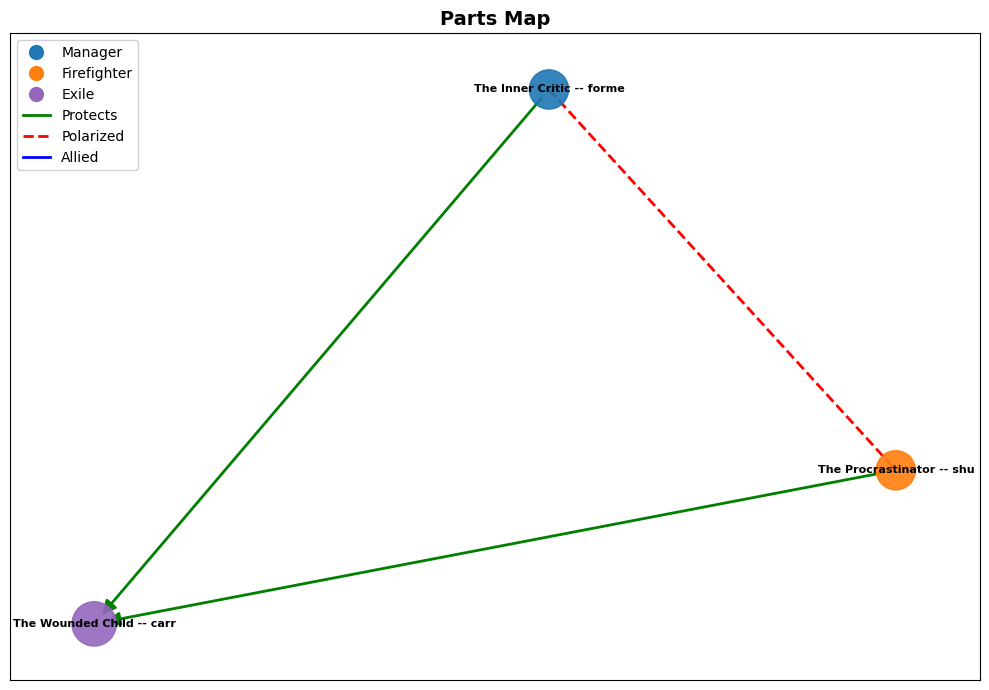

In [6]:
draw_parts_map(graph)

Graph now has 4 nodes and 4 edges.

Re-drawing the Parts Map with the new Part:


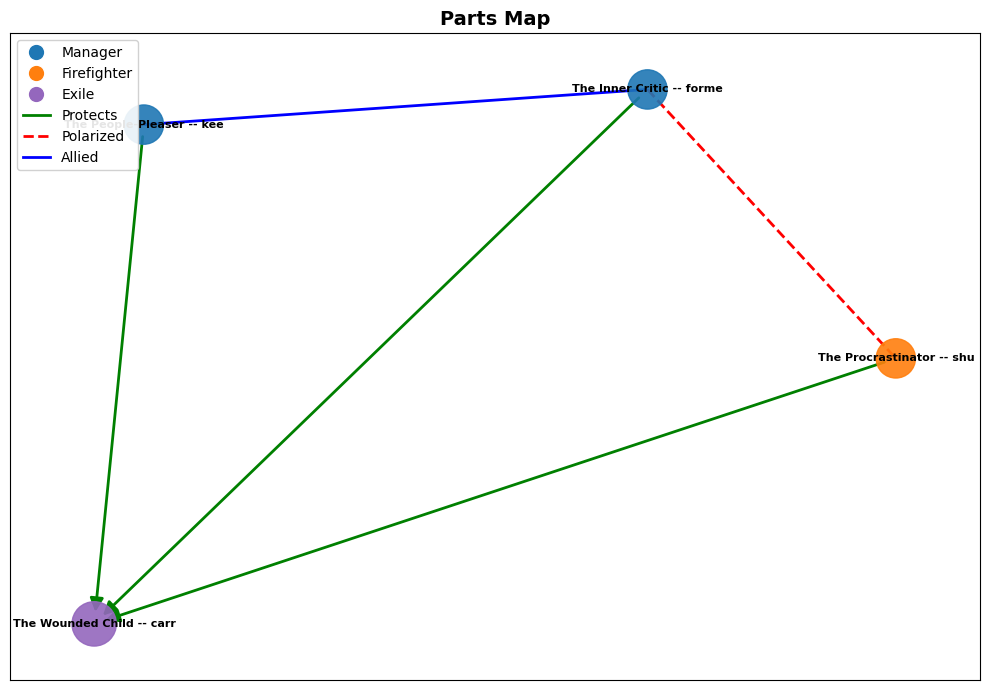

In [7]:
# Add a second Manager: The People-Pleaser
people_pleaser = Manager(
    narrative="The People-Pleaser -- keeps everyone happy so they won't leave",
    age=9,
    intent="Maintain connection by meeting others' needs first",
    triggers=["disapproval", "conflict", "someone upset"],
    strategies=["agreeableness", "over-giving", "suppressing own needs"],
    rigidity=0.6,
)

graph.add_part(people_pleaser)

# People-Pleaser is ALLIED with the Inner Critic -- they cooperate
graph.add_edge(Edge(
    source_id=people_pleaser.id,
    target_id=manager.id,
    edge_type=EdgeType.ALLIED,
))

# People-Pleaser also PROTECTS the Exile
graph.add_edge(Edge(
    source_id=people_pleaser.id,
    target_id=exile.id,
    edge_type=EdgeType.PROTECTS,
))

print(f"Graph now has {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
print("\nRe-drawing the Parts Map with the new Part:")
draw_parts_map(graph)

## JSON Export for D3.js / Gephi / Cytoscape

The `to_json()` method exports the Parts Map as a JSON-serialisable dictionary, compatible with force-directed graph visualisation tools. This is the data interchange format -- V1 provides the data, not the rendering.

In [8]:
parts_map = graph.to_json()
print(json.dumps(parts_map, indent=2))

{
  "nodes": [
    {
      "id": "23eba1ef-e162-405d-809c-1cafa71d98e4",
      "label": "The Inner Critic -- formed at age 12 after school ",
      "type": "manager",
      "state": "idle",
      "trust_level": 0.5
    },
    {
      "id": "1448e8d8-8e25-446d-bf54-d1a50ff4e953",
      "label": "The Procrastinator -- shuts down when pressure is ",
      "type": "firefighter",
      "state": "dormant",
      "trust_level": 0.5
    },
    {
      "id": "2e8bfca5-a602-4902-be31-83aac0c72b4b",
      "label": "The Wounded Child -- carries shame from early scho",
      "type": "exile",
      "state": "isolated",
      "trust_level": 0.5,
      "emotional_charge": 0.7
    },
    {
      "id": "5cfcaca4-8c54-4e0f-a989-cd37fbb33ea3",
      "label": "The People-Pleaser -- keeps everyone happy so they",
      "type": "manager",
      "state": "idle",
      "trust_level": 0.5
    }
  ],
  "edges": [
    {
      "source": "23eba1ef-e162-405d-809c-1cafa71d98e4",
      "target": "2e8bfca5-a602-4902-be

## Summary

In this notebook we:

- Built a `ProtectionGraph` with multiple Parts and typed edges
- Queried the graph: `get_protectors_of()`, `get_exiles()`, `get_polarized_pairs()`
- Visualised the Parts Map using networkx and matplotlib
- Exported the graph as JSON for use with external visualisation tools

**Next:** In [03_six_fs_workflow.ipynb](03_six_fs_workflow.ipynb), we walk through the 6 Fs -- the core algorithm for engaging with Protectors.